In [2]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 140

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6
compute_val_at = 0

In [3]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\lai\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [5]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [6]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(df['high'], color='red', label='high')
    ax1.legend(loc='best')
 
    ax2.plot(df['low'], color='red', label='low')
    ax2.legend(loc='best')
    plt.show()

             high           low     close    change      50ma     100ma  \
199  4.445337e-14  6.182380e-03  0.357085 -0.000150  0.351429  0.351070   
200  2.002002e-03  1.545595e-02  0.356606 -0.000060  0.351433  0.351063   
201  1.301301e-02  7.727975e-03  0.356893  0.000035  0.351445  0.351060   
202  4.445337e-14  1.545595e-03  0.357133  0.000015  0.351502  0.351082   
203  6.006006e-03  6.863821e-14  0.358138  0.000095  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


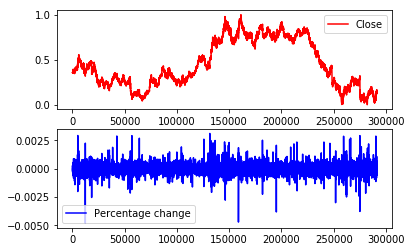

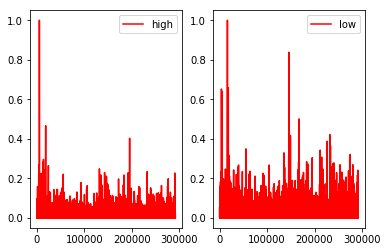

In [7]:
plot_stock(df)

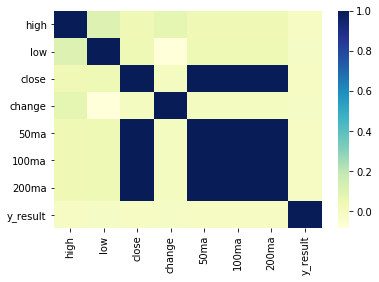

In [8]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [9]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7
Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 7) (174613,) (70626, 120, 7) (70626,)
7


In [11]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [12]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [13]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [14]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [15]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [16]:
interation_compute_val = 40
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == compute_val_at):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/140 Iteration: 5 Train loss: 0.671233 Train acc: 0.741211
Epoch: 0/140 Iteration: 10 Train loss: 0.623091 Train acc: 0.756836
Epoch: 0/140 Iteration: 15 Train loss: 0.621891 Train acc: 0.740234
Epoch: 0/140 Iteration: 20 Train loss: 0.479946 Train acc: 0.826660
Epoch: 0/140 Iteration: 25 Train loss: 0.602635 Train acc: 0.765625
Epoch: 0/140 Iteration: 30 Train loss: 0.473999 Train acc: 0.812500
Epoch: 0/140 Iteration: 35 Train loss: 0.362995 Train acc: 0.869629
Epoch: 0/140 Iteration: 40 Train loss: 0.495250 Train acc: 0.798340
Epoch: 0/140 Iteration: 40 Validation loss: 1.699282 Validation acc: 0.365522
Epoch: 0/140 Iteration: 45 Train loss: 0.548381 Train acc: 0.784180
Epoch: 0/140 Iteration: 50 Train loss: 0.491166 Train acc: 0.843750
Epoch: 0/140 Iteration: 55 Train loss: 0.650931 Train acc: 0.718262
Epoch: 0/140 Iteration: 60 Train loss: 0.674822 Train acc: 0.717773
Epoch: 0/140 Iteration: 65 Train loss: 

Epoch: 6/140 Iteration: 525 Train loss: 0.632214 Train acc: 0.749023
Epoch: 6/140 Iteration: 530 Train loss: 0.522541 Train acc: 0.817871
Epoch: 6/140 Iteration: 535 Train loss: 0.624333 Train acc: 0.743164
Epoch: 6/140 Iteration: 540 Train loss: 0.510484 Train acc: 0.812500
Epoch: 6/140 Iteration: 545 Train loss: 0.376363 Train acc: 0.869629
Epoch: 6/140 Iteration: 550 Train loss: 0.641640 Train acc: 0.767090
Epoch: 6/140 Iteration: 555 Train loss: 0.615374 Train acc: 0.739746
Epoch: 6/140 Iteration: 560 Train loss: 0.486927 Train acc: 0.866211
Epoch: 6/140 Iteration: 560 Validation loss: 1.515348 Validation acc: 0.411578
Epoch: 6/140 Iteration: 565 Train loss: 0.635868 Train acc: 0.728027
Epoch: 6/140 Iteration: 570 Train loss: 0.667876 Train acc: 0.715820
Epoch: 6/140 Iteration: 575 Train loss: 0.720521 Train acc: 0.678223
Epoch: 6/140 Iteration: 580 Train loss: 0.717837 Train acc: 0.702637
Epoch: 6/140 Iteration: 585 Train loss: 0.729669 Train acc: 0.647461
Epoch: 6/140 Iteration: 

Epoch: 12/140 Iteration: 1045 Train loss: 0.559120 Train acc: 0.772949
Epoch: 12/140 Iteration: 1050 Train loss: 0.417205 Train acc: 0.833984
Epoch: 12/140 Iteration: 1055 Train loss: 0.318827 Train acc: 0.886230
Epoch: 12/140 Iteration: 1060 Train loss: 0.465881 Train acc: 0.817383
Epoch: 12/140 Iteration: 1065 Train loss: 0.630602 Train acc: 0.753906
Epoch: 12/140 Iteration: 1070 Train loss: 0.464281 Train acc: 0.833984
Epoch: 12/140 Iteration: 1075 Train loss: 0.651699 Train acc: 0.740234
Epoch: 12/140 Iteration: 1080 Train loss: 0.635655 Train acc: 0.727539
Epoch: 12/140 Iteration: 1080 Validation loss: 1.652232 Validation acc: 0.384421
Epoch: 12/140 Iteration: 1085 Train loss: 0.627727 Train acc: 0.761719
Epoch: 12/140 Iteration: 1090 Train loss: 0.706085 Train acc: 0.682617
Epoch: 12/140 Iteration: 1095 Train loss: 0.720327 Train acc: 0.641602
Epoch: 12/140 Iteration: 1100 Train loss: 0.638039 Train acc: 0.729004
Epoch: 12/140 Iteration: 1105 Train loss: 0.683099 Train acc: 0.709

Epoch: 18/140 Iteration: 1555 Train loss: 0.592841 Train acc: 0.748535
Epoch: 18/140 Iteration: 1560 Train loss: 0.406493 Train acc: 0.855469
Epoch: 18/140 Iteration: 1560 Validation loss: 1.783611 Validation acc: 0.342572
Epoch: 18/140 Iteration: 1565 Train loss: 0.373433 Train acc: 0.858398
Epoch: 18/140 Iteration: 1570 Train loss: 0.467694 Train acc: 0.808105
Epoch: 18/140 Iteration: 1575 Train loss: 0.522587 Train acc: 0.784180
Epoch: 18/140 Iteration: 1580 Train loss: 0.474581 Train acc: 0.838867
Epoch: 18/140 Iteration: 1585 Train loss: 0.682292 Train acc: 0.719238
Epoch: 18/140 Iteration: 1590 Train loss: 0.725848 Train acc: 0.699219
Epoch: 18/140 Iteration: 1595 Train loss: 0.688408 Train acc: 0.713379
Epoch: 18/140 Iteration: 1600 Train loss: 0.674450 Train acc: 0.697266
Epoch: 18/140 Iteration: 1600 Validation loss: 1.681258 Validation acc: 0.379509
Epoch: 18/140 Iteration: 1605 Train loss: 0.755679 Train acc: 0.637207
Epoch: 18/140 Iteration: 1610 Train loss: 0.739693 Train 

Epoch: 24/140 Iteration: 2060 Train loss: 0.452274 Train acc: 0.823730
Epoch: 24/140 Iteration: 2065 Train loss: 0.530881 Train acc: 0.799316
Epoch: 24/140 Iteration: 2070 Train loss: 0.407210 Train acc: 0.845703
Epoch: 24/140 Iteration: 2075 Train loss: 0.313774 Train acc: 0.888672
Epoch: 24/140 Iteration: 2080 Train loss: 0.437482 Train acc: 0.825195
Epoch: 24/140 Iteration: 2080 Validation loss: 1.926260 Validation acc: 0.343089
Epoch: 24/140 Iteration: 2085 Train loss: 0.483847 Train acc: 0.822754
Epoch: 24/140 Iteration: 2090 Train loss: 0.418723 Train acc: 0.850586
Epoch: 24/140 Iteration: 2095 Train loss: 0.611630 Train acc: 0.761719
Epoch: 24/140 Iteration: 2100 Train loss: 0.750052 Train acc: 0.670410
Epoch: 24/140 Iteration: 2105 Train loss: 0.659727 Train acc: 0.726074
Epoch: 24/140 Iteration: 2110 Train loss: 0.763657 Train acc: 0.658203
Epoch: 24/140 Iteration: 2115 Train loss: 0.687772 Train acc: 0.710938
Epoch: 24/140 Iteration: 2120 Train loss: 0.697066 Train acc: 0.700

Epoch: 30/140 Iteration: 2565 Train loss: 0.456690 Train acc: 0.823730
Epoch: 30/140 Iteration: 2570 Train loss: 0.456993 Train acc: 0.823242
Epoch: 30/140 Iteration: 2575 Train loss: 0.519782 Train acc: 0.808594
Epoch: 30/140 Iteration: 2580 Train loss: 0.396200 Train acc: 0.857422
Epoch: 30/140 Iteration: 2585 Train loss: 0.295519 Train acc: 0.894043
Epoch: 30/140 Iteration: 2590 Train loss: 0.421777 Train acc: 0.838379
Epoch: 30/140 Iteration: 2595 Train loss: 0.453508 Train acc: 0.827148
Epoch: 30/140 Iteration: 2600 Train loss: 0.397132 Train acc: 0.877441
Epoch: 30/140 Iteration: 2600 Validation loss: 1.784188 Validation acc: 0.379107
Epoch: 30/140 Iteration: 2605 Train loss: 0.550589 Train acc: 0.781250
Epoch: 30/140 Iteration: 2610 Train loss: 0.601070 Train acc: 0.752930
Epoch: 30/140 Iteration: 2615 Train loss: 0.614426 Train acc: 0.761719
Epoch: 30/140 Iteration: 2620 Train loss: 0.738903 Train acc: 0.667969
Epoch: 30/140 Iteration: 2625 Train loss: 0.725596 Train acc: 0.678

Epoch: 36/140 Iteration: 3075 Train loss: 0.444511 Train acc: 0.827637
Epoch: 36/140 Iteration: 3080 Train loss: 0.465133 Train acc: 0.821289
Epoch: 36/140 Iteration: 3080 Validation loss: 1.804720 Validation acc: 0.350672
Epoch: 36/140 Iteration: 3085 Train loss: 0.481774 Train acc: 0.820312
Epoch: 36/140 Iteration: 3090 Train loss: 0.357271 Train acc: 0.868164
Epoch: 36/140 Iteration: 3095 Train loss: 0.296618 Train acc: 0.896973
Epoch: 36/140 Iteration: 3100 Train loss: 0.376960 Train acc: 0.853516
Epoch: 36/140 Iteration: 3105 Train loss: 0.426671 Train acc: 0.837402
Epoch: 36/140 Iteration: 3110 Train loss: 0.369497 Train acc: 0.869141
Epoch: 36/140 Iteration: 3115 Train loss: 0.551906 Train acc: 0.779785
Epoch: 36/140 Iteration: 3120 Train loss: 0.539356 Train acc: 0.795410
Epoch: 36/140 Iteration: 3120 Validation loss: 1.907542 Validation acc: 0.340389
Epoch: 36/140 Iteration: 3125 Train loss: 0.551386 Train acc: 0.789062
Epoch: 36/140 Iteration: 3130 Train loss: 0.634714 Train 

Epoch: 42/140 Iteration: 3580 Train loss: 0.488240 Train acc: 0.819824
Epoch: 42/140 Iteration: 3585 Train loss: 0.463893 Train acc: 0.820312
Epoch: 42/140 Iteration: 3590 Train loss: 0.419725 Train acc: 0.843750
Epoch: 42/140 Iteration: 3595 Train loss: 0.493944 Train acc: 0.811523
Epoch: 42/140 Iteration: 3600 Train loss: 0.368634 Train acc: 0.869629
Epoch: 42/140 Iteration: 3600 Validation loss: 1.884622 Validation acc: 0.348001
Epoch: 42/140 Iteration: 3605 Train loss: 0.301917 Train acc: 0.889648
Epoch: 42/140 Iteration: 3610 Train loss: 0.382039 Train acc: 0.852051
Epoch: 42/140 Iteration: 3615 Train loss: 0.390787 Train acc: 0.857422
Epoch: 42/140 Iteration: 3620 Train loss: 0.398636 Train acc: 0.859375
Epoch: 42/140 Iteration: 3625 Train loss: 0.546730 Train acc: 0.789551
Epoch: 42/140 Iteration: 3630 Train loss: 0.483176 Train acc: 0.829590
Epoch: 42/140 Iteration: 3635 Train loss: 0.535206 Train acc: 0.796875
Epoch: 42/140 Iteration: 3640 Train loss: 0.565205 Train acc: 0.753

Epoch: 48/140 Iteration: 4085 Train loss: 0.569328 Train acc: 0.777344
Epoch: 48/140 Iteration: 4090 Train loss: 0.467635 Train acc: 0.833984
Epoch: 48/140 Iteration: 4095 Train loss: 0.479960 Train acc: 0.808105
Epoch: 48/140 Iteration: 4100 Train loss: 0.425057 Train acc: 0.839844
Epoch: 48/140 Iteration: 4105 Train loss: 0.480683 Train acc: 0.819336
Epoch: 48/140 Iteration: 4110 Train loss: 0.389692 Train acc: 0.847656
Epoch: 48/140 Iteration: 4115 Train loss: 0.303270 Train acc: 0.884766
Epoch: 48/140 Iteration: 4120 Train loss: 0.407404 Train acc: 0.842285
Epoch: 48/140 Iteration: 4120 Validation loss: 1.676428 Validation acc: 0.384306
Epoch: 48/140 Iteration: 4125 Train loss: 0.400631 Train acc: 0.848633
Epoch: 48/140 Iteration: 4130 Train loss: 0.389429 Train acc: 0.866211
Epoch: 48/140 Iteration: 4135 Train loss: 0.551244 Train acc: 0.782715
Epoch: 48/140 Iteration: 4140 Train loss: 0.499479 Train acc: 0.817871
Epoch: 48/140 Iteration: 4145 Train loss: 0.579372 Train acc: 0.777

Epoch: 54/140 Iteration: 4595 Train loss: 0.614561 Train acc: 0.754395
Epoch: 54/140 Iteration: 4600 Train loss: 0.444178 Train acc: 0.838379
Epoch: 54/140 Iteration: 4600 Validation loss: 1.843231 Validation acc: 0.380759
Epoch: 54/140 Iteration: 4605 Train loss: 0.512910 Train acc: 0.796875
Epoch: 54/140 Iteration: 4610 Train loss: 0.402557 Train acc: 0.859863
Epoch: 54/140 Iteration: 4615 Train loss: 0.478156 Train acc: 0.826660
Epoch: 54/140 Iteration: 4620 Train loss: 0.339774 Train acc: 0.871094
Epoch: 54/140 Iteration: 4625 Train loss: 0.293804 Train acc: 0.892090
Epoch: 54/140 Iteration: 4630 Train loss: 0.375866 Train acc: 0.867188
Epoch: 54/140 Iteration: 4635 Train loss: 0.407911 Train acc: 0.854004
Epoch: 54/140 Iteration: 4640 Train loss: 0.391908 Train acc: 0.866211
Epoch: 54/140 Iteration: 4640 Validation loss: 1.715393 Validation acc: 0.381391
Epoch: 54/140 Iteration: 4645 Train loss: 0.508329 Train acc: 0.795898
Epoch: 54/140 Iteration: 4650 Train loss: 0.491832 Train 

Epoch: 59/140 Iteration: 5100 Train loss: 0.507108 Train acc: 0.787598
Epoch: 60/140 Iteration: 5105 Train loss: 0.585599 Train acc: 0.761230
Epoch: 60/140 Iteration: 5110 Train loss: 0.501687 Train acc: 0.812988
Epoch: 60/140 Iteration: 5115 Train loss: 0.597113 Train acc: 0.756836
Epoch: 60/140 Iteration: 5120 Train loss: 0.376137 Train acc: 0.859863
Epoch: 60/140 Iteration: 5120 Validation loss: 1.661712 Validation acc: 0.419534
Epoch: 60/140 Iteration: 5125 Train loss: 0.488838 Train acc: 0.812500
Epoch: 60/140 Iteration: 5130 Train loss: 0.351715 Train acc: 0.864258
Epoch: 60/140 Iteration: 5135 Train loss: 0.293546 Train acc: 0.896484
Epoch: 60/140 Iteration: 5140 Train loss: 0.370127 Train acc: 0.858398
Epoch: 60/140 Iteration: 5145 Train loss: 0.376638 Train acc: 0.862793
Epoch: 60/140 Iteration: 5150 Train loss: 0.365786 Train acc: 0.884277
Epoch: 60/140 Iteration: 5155 Train loss: 0.486715 Train acc: 0.803711
Epoch: 60/140 Iteration: 5160 Train loss: 0.507710 Train acc: 0.810

Epoch: 65/140 Iteration: 5605 Train loss: 0.532452 Train acc: 0.786621
Epoch: 65/140 Iteration: 5610 Train loss: 0.511578 Train acc: 0.803711
Epoch: 66/140 Iteration: 5615 Train loss: 0.631501 Train acc: 0.757812
Epoch: 66/140 Iteration: 5620 Train loss: 0.532294 Train acc: 0.799805
Epoch: 66/140 Iteration: 5625 Train loss: 0.526533 Train acc: 0.783203
Epoch: 66/140 Iteration: 5630 Train loss: 0.435244 Train acc: 0.834961
Epoch: 66/140 Iteration: 5635 Train loss: 0.549662 Train acc: 0.783203
Epoch: 66/140 Iteration: 5640 Train loss: 0.443597 Train acc: 0.824219
Epoch: 66/140 Iteration: 5640 Validation loss: 1.630705 Validation acc: 0.400419
Epoch: 66/140 Iteration: 5645 Train loss: 0.311881 Train acc: 0.885742
Epoch: 66/140 Iteration: 5650 Train loss: 0.398405 Train acc: 0.843262
Epoch: 66/140 Iteration: 5655 Train loss: 0.400090 Train acc: 0.850586
Epoch: 66/140 Iteration: 5660 Train loss: 0.417837 Train acc: 0.852539
Epoch: 66/140 Iteration: 5665 Train loss: 0.531878 Train acc: 0.777

Epoch: 71/140 Iteration: 6115 Train loss: 0.517688 Train acc: 0.789551
Epoch: 71/140 Iteration: 6120 Train loss: 0.465618 Train acc: 0.823730
Epoch: 71/140 Iteration: 6120 Validation loss: 1.958196 Validation acc: 0.368810
Epoch: 72/140 Iteration: 6125 Train loss: 0.542572 Train acc: 0.799316
Epoch: 72/140 Iteration: 6130 Train loss: 0.424814 Train acc: 0.847656
Epoch: 72/140 Iteration: 6135 Train loss: 0.491040 Train acc: 0.809570
Epoch: 72/140 Iteration: 6140 Train loss: 0.394861 Train acc: 0.847656
Epoch: 72/140 Iteration: 6145 Train loss: 0.486616 Train acc: 0.810059
Epoch: 72/140 Iteration: 6150 Train loss: 0.326362 Train acc: 0.879395
Epoch: 72/140 Iteration: 6155 Train loss: 0.268219 Train acc: 0.903809
Epoch: 72/140 Iteration: 6160 Train loss: 0.371121 Train acc: 0.854004
Epoch: 72/140 Iteration: 6160 Validation loss: 1.766887 Validation acc: 0.380673
Epoch: 72/140 Iteration: 6165 Train loss: 0.340010 Train acc: 0.881836
Epoch: 72/140 Iteration: 6170 Train loss: 0.381173 Train 

Epoch: 77/140 Iteration: 6620 Train loss: 0.602345 Train acc: 0.758789
Epoch: 77/140 Iteration: 6625 Train loss: 0.497410 Train acc: 0.809082
Epoch: 77/140 Iteration: 6630 Train loss: 0.473195 Train acc: 0.812012
Epoch: 78/140 Iteration: 6635 Train loss: 0.493358 Train acc: 0.822754
Epoch: 78/140 Iteration: 6640 Train loss: 0.399931 Train acc: 0.859375
Epoch: 78/140 Iteration: 6640 Validation loss: 2.035206 Validation acc: 0.356575
Epoch: 78/140 Iteration: 6645 Train loss: 0.471080 Train acc: 0.819824
Epoch: 78/140 Iteration: 6650 Train loss: 0.392496 Train acc: 0.847656
Epoch: 78/140 Iteration: 6655 Train loss: 0.464681 Train acc: 0.819824
Epoch: 78/140 Iteration: 6660 Train loss: 0.320563 Train acc: 0.880859
Epoch: 78/140 Iteration: 6665 Train loss: 0.283130 Train acc: 0.896973
Epoch: 78/140 Iteration: 6670 Train loss: 0.385605 Train acc: 0.851074
Epoch: 78/140 Iteration: 6675 Train loss: 0.333440 Train acc: 0.894043
Epoch: 78/140 Iteration: 6680 Train loss: 0.393549 Train acc: 0.872

Epoch: 83/140 Iteration: 7125 Train loss: 0.441925 Train acc: 0.834473
Epoch: 83/140 Iteration: 7130 Train loss: 0.574754 Train acc: 0.755371
Epoch: 83/140 Iteration: 7135 Train loss: 0.476047 Train acc: 0.799805
Epoch: 83/140 Iteration: 7140 Train loss: 0.441797 Train acc: 0.838867
Epoch: 84/140 Iteration: 7145 Train loss: 0.518163 Train acc: 0.811523
Epoch: 84/140 Iteration: 7150 Train loss: 0.382726 Train acc: 0.873535
Epoch: 84/140 Iteration: 7155 Train loss: 0.425360 Train acc: 0.837402
Epoch: 84/140 Iteration: 7160 Train loss: 0.334357 Train acc: 0.884766
Epoch: 84/140 Iteration: 7160 Validation loss: 2.144405 Validation acc: 0.312371
Epoch: 84/140 Iteration: 7165 Train loss: 0.451291 Train acc: 0.830078
Epoch: 84/140 Iteration: 7170 Train loss: 0.324807 Train acc: 0.884766
Epoch: 84/140 Iteration: 7175 Train loss: 0.299774 Train acc: 0.897461
Epoch: 84/140 Iteration: 7180 Train loss: 0.399718 Train acc: 0.833496
Epoch: 84/140 Iteration: 7185 Train loss: 0.340271 Train acc: 0.887

Epoch: 89/140 Iteration: 7635 Train loss: 0.654354 Train acc: 0.732422
Epoch: 89/140 Iteration: 7640 Train loss: 0.679338 Train acc: 0.716797
Epoch: 89/140 Iteration: 7640 Validation loss: 1.965274 Validation acc: 0.382970
Epoch: 89/140 Iteration: 7645 Train loss: 0.610821 Train acc: 0.736328
Epoch: 89/140 Iteration: 7650 Train loss: 0.664291 Train acc: 0.739258
Epoch: 90/140 Iteration: 7655 Train loss: 0.518965 Train acc: 0.805176
Epoch: 90/140 Iteration: 7660 Train loss: 0.410128 Train acc: 0.861328
Epoch: 90/140 Iteration: 7665 Train loss: 0.411554 Train acc: 0.835938
Epoch: 90/140 Iteration: 7670 Train loss: 0.333386 Train acc: 0.879395
Epoch: 90/140 Iteration: 7675 Train loss: 0.443181 Train acc: 0.828613
Epoch: 90/140 Iteration: 7680 Train loss: 0.341809 Train acc: 0.875488
Epoch: 90/140 Iteration: 7680 Validation loss: 2.082378 Validation acc: 0.339944
Epoch: 90/140 Iteration: 7685 Train loss: 0.277421 Train acc: 0.897461
Epoch: 90/140 Iteration: 7690 Train loss: 0.331339 Train 

Epoch: 95/140 Iteration: 8140 Train loss: 0.492310 Train acc: 0.814453
Epoch: 95/140 Iteration: 8145 Train loss: 0.603606 Train acc: 0.731934
Epoch: 95/140 Iteration: 8150 Train loss: 0.564015 Train acc: 0.764648
Epoch: 95/140 Iteration: 8155 Train loss: 0.500487 Train acc: 0.815430
Epoch: 95/140 Iteration: 8160 Train loss: 0.622849 Train acc: 0.730957
Epoch: 95/140 Iteration: 8160 Validation loss: 2.020464 Validation acc: 0.371697
Epoch: 96/140 Iteration: 8165 Train loss: 0.487644 Train acc: 0.815430
Epoch: 96/140 Iteration: 8170 Train loss: 0.393532 Train acc: 0.861328
Epoch: 96/140 Iteration: 8175 Train loss: 0.394238 Train acc: 0.846191
Epoch: 96/140 Iteration: 8180 Train loss: 0.341376 Train acc: 0.879395
Epoch: 96/140 Iteration: 8185 Train loss: 0.391382 Train acc: 0.863281
Epoch: 96/140 Iteration: 8190 Train loss: 0.325582 Train acc: 0.883789
Epoch: 96/140 Iteration: 8195 Train loss: 0.280649 Train acc: 0.900879
Epoch: 96/140 Iteration: 8200 Train loss: 0.351680 Train acc: 0.866

Epoch: 101/140 Iteration: 8645 Train loss: 0.441280 Train acc: 0.841797
Epoch: 101/140 Iteration: 8650 Train loss: 0.466516 Train acc: 0.829102
Epoch: 101/140 Iteration: 8655 Train loss: 0.538389 Train acc: 0.788086
Epoch: 101/140 Iteration: 8660 Train loss: 0.590448 Train acc: 0.769043
Epoch: 101/140 Iteration: 8665 Train loss: 0.465658 Train acc: 0.819824
Epoch: 101/140 Iteration: 8670 Train loss: 0.504115 Train acc: 0.802734
Epoch: 102/140 Iteration: 8675 Train loss: 0.472199 Train acc: 0.825195
Epoch: 102/140 Iteration: 8680 Train loss: 0.374652 Train acc: 0.870605
Epoch: 102/140 Iteration: 8680 Validation loss: 1.965617 Validation acc: 0.395091
Epoch: 102/140 Iteration: 8685 Train loss: 0.390616 Train acc: 0.848633
Epoch: 102/140 Iteration: 8690 Train loss: 0.328167 Train acc: 0.877930
Epoch: 102/140 Iteration: 8695 Train loss: 0.465825 Train acc: 0.824707
Epoch: 102/140 Iteration: 8700 Train loss: 0.319891 Train acc: 0.887695
Epoch: 102/140 Iteration: 8705 Train loss: 0.268485 Tr

Epoch: 107/140 Iteration: 9150 Train loss: 0.408902 Train acc: 0.831543
Epoch: 107/140 Iteration: 9155 Train loss: 0.371540 Train acc: 0.873047
Epoch: 107/140 Iteration: 9160 Train loss: 0.491581 Train acc: 0.815918
Epoch: 107/140 Iteration: 9160 Validation loss: 2.143549 Validation acc: 0.363755
Epoch: 107/140 Iteration: 9165 Train loss: 0.504404 Train acc: 0.784668
Epoch: 107/140 Iteration: 9170 Train loss: 0.609380 Train acc: 0.755859
Epoch: 107/140 Iteration: 9175 Train loss: 0.500466 Train acc: 0.812012
Epoch: 107/140 Iteration: 9180 Train loss: 0.534448 Train acc: 0.783203
Epoch: 108/140 Iteration: 9185 Train loss: 0.461545 Train acc: 0.833008
Epoch: 108/140 Iteration: 9190 Train loss: 0.375830 Train acc: 0.865234
Epoch: 108/140 Iteration: 9195 Train loss: 0.372464 Train acc: 0.855469
Epoch: 108/140 Iteration: 9200 Train loss: 0.323438 Train acc: 0.884277
Epoch: 108/140 Iteration: 9200 Validation loss: 2.111292 Validation acc: 0.358944
Epoch: 108/140 Iteration: 9205 Train loss: 0

Epoch: 113/140 Iteration: 9645 Train loss: 0.332150 Train acc: 0.879883
Epoch: 113/140 Iteration: 9650 Train loss: 0.256971 Train acc: 0.915039
Epoch: 113/140 Iteration: 9655 Train loss: 0.285950 Train acc: 0.915527
Epoch: 113/140 Iteration: 9660 Train loss: 0.379902 Train acc: 0.857422
Epoch: 113/140 Iteration: 9665 Train loss: 0.357272 Train acc: 0.875000
Epoch: 113/140 Iteration: 9670 Train loss: 0.443223 Train acc: 0.824219
Epoch: 113/140 Iteration: 9675 Train loss: 0.445678 Train acc: 0.838867
Epoch: 113/140 Iteration: 9680 Train loss: 0.647880 Train acc: 0.747070
Epoch: 113/140 Iteration: 9680 Validation loss: 2.135297 Validation acc: 0.394876
Epoch: 113/140 Iteration: 9685 Train loss: 0.463377 Train acc: 0.816406
Epoch: 113/140 Iteration: 9690 Train loss: 0.482224 Train acc: 0.814453
Epoch: 114/140 Iteration: 9695 Train loss: 0.437478 Train acc: 0.849609
Epoch: 114/140 Iteration: 9700 Train loss: 0.375708 Train acc: 0.859375
Epoch: 114/140 Iteration: 9705 Train loss: 0.405292 Tr

Epoch: 119/140 Iteration: 10145 Train loss: 0.280182 Train acc: 0.900879
Epoch: 119/140 Iteration: 10150 Train loss: 0.242775 Train acc: 0.905762
Epoch: 119/140 Iteration: 10155 Train loss: 0.309163 Train acc: 0.886719
Epoch: 119/140 Iteration: 10160 Train loss: 0.267296 Train acc: 0.912109
Epoch: 119/140 Iteration: 10160 Validation loss: 1.951177 Validation acc: 0.397116
Epoch: 119/140 Iteration: 10165 Train loss: 0.289060 Train acc: 0.911621
Epoch: 119/140 Iteration: 10170 Train loss: 0.363030 Train acc: 0.852539
Epoch: 119/140 Iteration: 10175 Train loss: 0.353819 Train acc: 0.885742
Epoch: 119/140 Iteration: 10180 Train loss: 0.434544 Train acc: 0.831543
Epoch: 119/140 Iteration: 10185 Train loss: 0.422318 Train acc: 0.841309
Epoch: 119/140 Iteration: 10190 Train loss: 0.504494 Train acc: 0.797852
Epoch: 119/140 Iteration: 10195 Train loss: 0.431875 Train acc: 0.830566
Epoch: 119/140 Iteration: 10200 Train loss: 0.365319 Train acc: 0.867676
Epoch: 119/140 Iteration: 10200 Validatio

Epoch: 125/140 Iteration: 10640 Train loss: 0.320589 Train acc: 0.877930
Epoch: 125/140 Iteration: 10640 Validation loss: 2.042475 Validation acc: 0.388859
Epoch: 125/140 Iteration: 10645 Train loss: 0.321696 Train acc: 0.879395
Epoch: 125/140 Iteration: 10650 Train loss: 0.372111 Train acc: 0.870117
Epoch: 125/140 Iteration: 10655 Train loss: 0.296812 Train acc: 0.902832
Epoch: 125/140 Iteration: 10660 Train loss: 0.257026 Train acc: 0.907227
Epoch: 125/140 Iteration: 10665 Train loss: 0.273993 Train acc: 0.903809
Epoch: 125/140 Iteration: 10670 Train loss: 0.274445 Train acc: 0.910645
Epoch: 125/140 Iteration: 10675 Train loss: 0.271353 Train acc: 0.903809
Epoch: 125/140 Iteration: 10680 Train loss: 0.359199 Train acc: 0.861816
Epoch: 125/140 Iteration: 10680 Validation loss: 2.011740 Validation acc: 0.401224
Epoch: 125/140 Iteration: 10685 Train loss: 0.358655 Train acc: 0.872070
Epoch: 125/140 Iteration: 10690 Train loss: 0.447154 Train acc: 0.819824
Epoch: 125/140 Iteration: 10695

Epoch: 130/140 Iteration: 11130 Train loss: 0.456434 Train acc: 0.818848
Epoch: 130/140 Iteration: 11135 Train loss: 0.390665 Train acc: 0.861816
Epoch: 131/140 Iteration: 11140 Train loss: 0.475843 Train acc: 0.821777
Epoch: 131/140 Iteration: 11145 Train loss: 0.360511 Train acc: 0.875977
Epoch: 131/140 Iteration: 11150 Train loss: 0.345483 Train acc: 0.866211
Epoch: 131/140 Iteration: 11155 Train loss: 0.302083 Train acc: 0.899414
Epoch: 131/140 Iteration: 11160 Train loss: 0.368321 Train acc: 0.859863
Epoch: 131/140 Iteration: 11160 Validation loss: 2.142168 Validation acc: 0.352467
Epoch: 131/140 Iteration: 11165 Train loss: 0.278558 Train acc: 0.901855
Epoch: 131/140 Iteration: 11170 Train loss: 0.255098 Train acc: 0.906738
Epoch: 131/140 Iteration: 11175 Train loss: 0.296520 Train acc: 0.898926
Epoch: 131/140 Iteration: 11180 Train loss: 0.259795 Train acc: 0.921875
Epoch: 131/140 Iteration: 11185 Train loss: 0.297152 Train acc: 0.899902
Epoch: 131/140 Iteration: 11190 Train los

Epoch: 136/140 Iteration: 11625 Train loss: 0.430409 Train acc: 0.840332
Epoch: 136/140 Iteration: 11630 Train loss: 0.451965 Train acc: 0.828613
Epoch: 136/140 Iteration: 11635 Train loss: 0.456592 Train acc: 0.822754
Epoch: 136/140 Iteration: 11640 Train loss: 0.421779 Train acc: 0.826660
Epoch: 136/140 Iteration: 11640 Validation loss: 2.239351 Validation acc: 0.385642
Epoch: 136/140 Iteration: 11645 Train loss: 0.392094 Train acc: 0.873047
Epoch: 137/140 Iteration: 11650 Train loss: 0.480301 Train acc: 0.819824
Epoch: 137/140 Iteration: 11655 Train loss: 0.367634 Train acc: 0.875488
Epoch: 137/140 Iteration: 11660 Train loss: 0.358400 Train acc: 0.861328
Epoch: 137/140 Iteration: 11665 Train loss: 0.306041 Train acc: 0.895508
Epoch: 137/140 Iteration: 11670 Train loss: 0.416458 Train acc: 0.840820
Epoch: 137/140 Iteration: 11675 Train loss: 0.302772 Train acc: 0.894531
Epoch: 137/140 Iteration: 11680 Train loss: 0.270238 Train acc: 0.898438
Epoch: 137/140 Iteration: 11680 Validatio

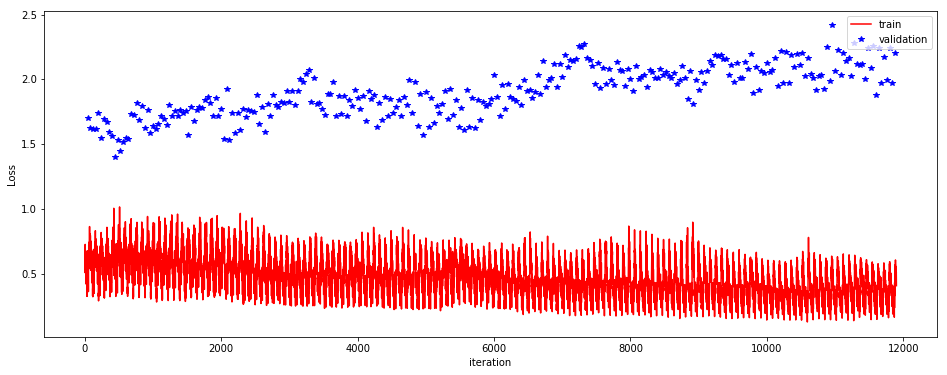

In [17]:
# Plot training and test loss
t = np.arange(iteration-1)
tt = t[t % interation_compute_val == compute_val_at]
tt = tt[1:]
plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', tt, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

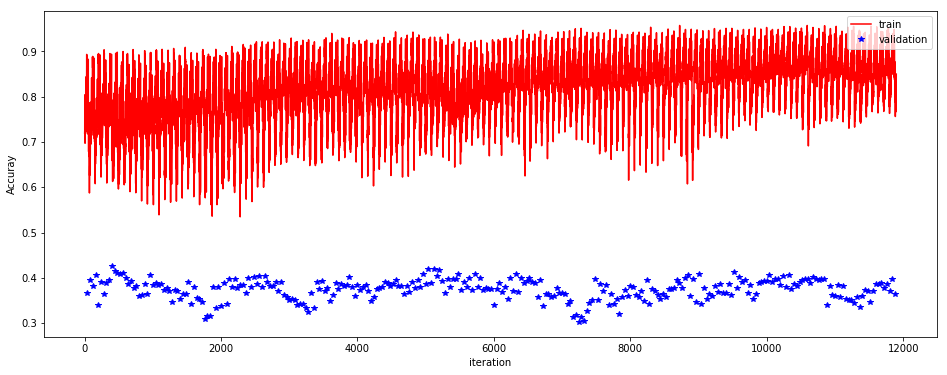

In [18]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', tt, validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [19]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    sess.run(tf.local_variables_initializer())
    saver = tf.train.import_meta_graph('checkpoints\har-lstm.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)        
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size): 
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([ accuracy,final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
0.431152
0.381836
0.470215
0.390137
0.455566
0.487305
0.424316
0.531738
0.475098
0.4375
0.361816
0.470215
0.417969
0.443848
0.332031
0.38916
0.376953
0.385254
0.286621
0.260254
0.227051
0.340332
0.336914
0.304199
0.260254
0.256348
0.280273
0.266113
0.289551
0.418457
0.340332
0.325195
0.241211
0.316406
Test accuracy: 0.365048


In [20]:
import datetime
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


SyntaxError: invalid syntax (<ipython-input-20-a2d1b987acee>, line 2)

In [ ]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

In [ ]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

In [ ]:
print(50%1)